In [1]:
import gradio as gr
import pandas as pd
import hopsworks
import numpy as np 
from dotenv import load_dotenv
import os
from tensorflow.keras.models import load_model
import datetime as dt
import mplfinance as mpf 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

c:\Users\User\miniconda3\envs\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# download model
load_dotenv()
api_key = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login(api_key_value=api_key, project="project0")
fs = project.get_feature_store()

mr = project.get_model_registry()
model = mr.get_model("btc_model", version=1)
model_dir = model.download()
# Load the model
model = load_model(model_dir + '/btc_model.h5')
print("Model downloaded")

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/308374
Connected. Call `.close()` to terminate connection gracefully.
Connected. Call `.close()` to terminate connection gracefully.


Model downloaded


In [3]:
# get last 365 days to use in prediction
btc_fg = fs.get_feature_group(name="btc", version=1)
query = btc_fg.select_all()
feature_join = btc_fg.select(["open_time", "close_time", 'open', 'high', 'low', 'close', 'volume'])
df = feature_join.read(online=False, dataframe_type="default", read_options={})
df_sorted = df.sort_values(by='open_time')
df = df_sorted.reset_index(drop=True)
historical_df = df.set_index("open_time")
historical_df

Finished: Reading data from Hopsworks, using Hive (3.88s) 


,close_time,open,high,low,close,volume
open_time,,,,,,
2018-01-01,2018-01-01 23:59:59.999,13715.65,13818.55,12750.00,13380.00,8609.915844
2018-01-02,2018-01-02 23:59:59.999,13382.16,15473.49,12890.02,14675.11,20078.092111
2018-01-03,2018-01-03 23:59:59.999,14690.00,15307.56,14150.00,14919.51,15905.667639
2018-01-04,2018-01-04 23:59:59.999,14919.51,15280.00,13918.04,15059.54,21329.649574
2018-01-05,2018-01-05 23:59:59.999,15059.56,17176.24,14600.00,16960.39,23251.491125
...,...,...,...,...,...,...
2024-01-07,2024-01-07 23:59:59.999,43968.32,44480.59,43572.09,43929.02,23023.850800
2024-01-08,2024-01-08 23:59:59.999,43929.01,47248.99,43175.00,46951.04,72814.575890
2024-01-09,2024-01-09 23:59:59.999,46951.04,47972.00,44748.67,46110.00,69927.666170


In [4]:
data_min, data_max = historical_df["close"].min(), historical_df["close"].max()
data = historical_df.iloc[-100:]
data_dates, data = data["close_time"].values, data["close"].values.reshape(-1, 1)

In [5]:
def scale(data):
    return (data - data_min) / (data_max - data_min) * 2 - 1

def unscale(data):
    return (data + 1) / 2 * (data_max - data_min) + data_min

In [63]:
def predict_ahead(data, n_ahead):
    # X.shape = (time_axis, input_size)
    _X = scale(np.copy(data))
    _y = None

    if len(_X.shape) == 2:
        _X = _X[np.newaxis, ...]
    for _ in range(n_ahead):
        y = model.predict(_X)[np.newaxis, ...]
        if _y is None:
            _y = y
        else:
            _y = np.concatenate((_y, y), axis=1)
        _X = np.concatenate((_X, y), axis=1)[:, y.shape[0]:]
    return unscale(_y[..., 0])

def predict_and_plot(n_ahead):
    n_ahead = int(n_ahead)
    pred = predict_ahead(data, n_ahead).flatten()
    pred = np.insert(pred, 0, data[-1])
    pred_dates = pd.date_range(start=data_dates[-1], periods = n_ahead + 1)

    plt.figure(figsize=(20,10))
    # Plot the historical data
    plt.plot(data_dates[-50:], data[-50:], label="Historical data")
    # Plot the predictions
    plt.plot(pred_dates, pred, label="Predictions", color = 'red', linewidth = 3, linestyle = '--')
    plt.legend(loc = "upper left", fontsize = 15)
    plt.title("BTCUSDT Price Prediction", fontsize=30)
    plt.xlabel("Date (YYYY-MM-DD)", fontsize=20)
    plt.ylabel("Price ($)", fontsize=20)

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))  # set major ticks to daily interval
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  # format the date display
    
    # Rotate and align the tick labels so they look better
    plt.gcf().autofmt_xdate()


    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    plt.savefig('predicted_prices.png', dpi=300)
    #plt.show()
    return 'predicted_prices.png'


1/1 [==============================] - 0s 55ms/step


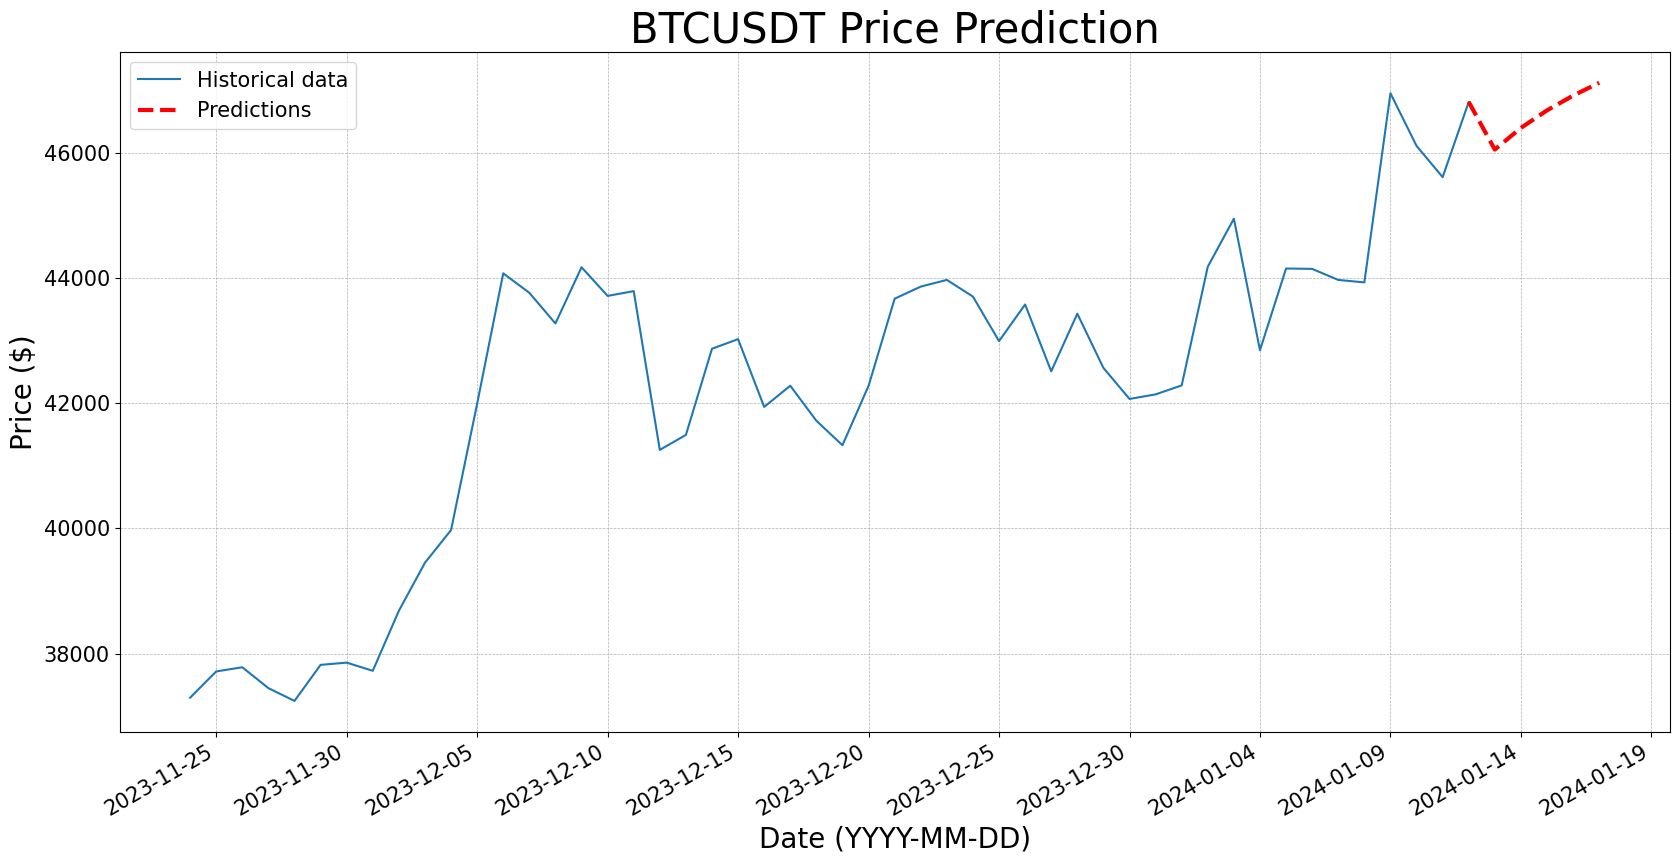

In [64]:
user_input_n = 5
a = predict_and_plot(user_input_n)

In [65]:
# Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# <center> BTC/USDT Price Prediction</center>")
    gr.Markdown("### Enter how many days ahead you want to see the BTC price predictions.")
    
    with gr.Row():
        with gr.Column(scale = 0):
            days_ahead = gr.Number(value=1, label="Days ahead")
            predict_button = gr.Button("Predict", scale = 0)

        output_image = gr.Image()

    # Define the function to be called when the button is pressed
    predict_button.click(predict_and_plot, inputs=[days_ahead], outputs=[output_image])
    
demo.launch(debug=True)


        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


1/1 [==============================] - 0s 51ms/step


1/1 [==============================] - 0s 53ms/step
Keyboard interruption in main thread... closing server.
